### Loading the models into JavaScript

After the models are prepared using the Keras API and the models are prepared into the respective `model{Node/Constraint}.js` they can be imported using `tensorflow.js`.

For the moment the `import` is done using `require`, which can be changed when `nodejs` is updated to `13.12` in conda.
The current version is `13.10`.

In [1]:
const fs = require('fs');
const path = require('path');

const tf = require('@tensorflow/tfjs-node');
const cv = require('canvas');
const base64 = require('base-64');

const code_dir = path.join('..', 'code')
const g2 = require(path.join(code_dir, 'g2'));
const models = require(path.join(code_dir, 'models.js'));
const toFullyConv = require(path.join(code_dir, 'toFullyConv.js'));

Now some mocks have to be created for some function.

`g2` needs a `CanvasRenderingContext2D` to check `instanceof ctx` and  
`NodeModel` and `ConstraintModel` use `window.atob` to decode `base64` data.

In [2]:
global.CanvasRenderingContext2D = cv.CanvasRenderingContext2D;
const window = { atob: base64.decode };

[Function: CanvasRenderingContext2D]

The same five images as in the notebooks before are loaded.


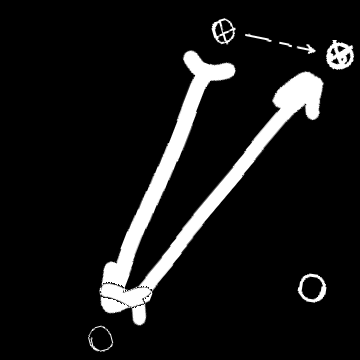
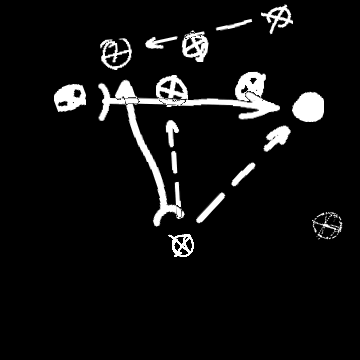
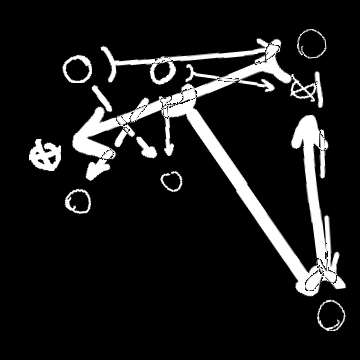
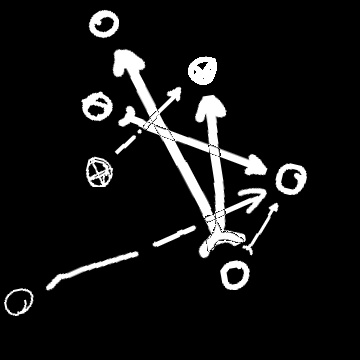
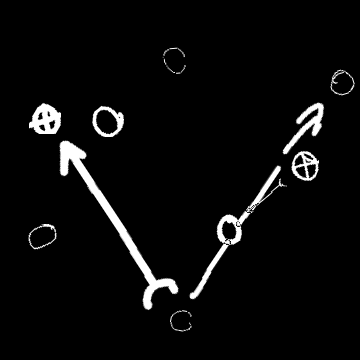

In [3]:
const data_dir = path.join('..', '..', '..', 'data', 'sep_interim_02');

const images = [];

(async () => {
    for (let i = 0; i < 5; ++i) {
        const canvas = cv.createCanvas(360, 360);
        const ctx = canvas.getContext('2d');
        const image_path = fs.readFileSync(path.join(data_dir, `${i}.png`));
        const image = await cv.loadImage(image_path);
        ctx.drawImage(image, 0, 0, canvas.width, canvas.height);
        images.push(canvas)
    }
    $$.html(`<div style="display:flex; flex-direction: row;"> ${images.map(c => 
        `<img style='margin: 1px; zoom: 0.4' src='${c.toDataURL()}'></img>`).join('')}
    </div>`);
})()

In [4]:
deepmech = {
    nodeDetector: (async () => {
        return toFullyConv(await tf.loadLayersModel(new models.NodeModel()));
    })(),

    constraintDetector: (async () => {
        return await tf.loadLayersModel(new models.ConstraintModel());
    })(),

    detectNodes(image, nodeDetector) {
        const prediction = nodeDetector.predict(image, { batch_size: 1 }).arraySync()[0];

        function formatPrediction(pred, idx) {
            const y = idx * 4;
            return pred.flatMap((inner, i) => {
                const max = Math.max(...inner);
                const maxIndex = inner.indexOf(max);
                const x = i * 4;
                return { x, y, max, maxIndex, b: 32, h: 32 }
            });
        }
        function removeOverlaps(boxes) {
            const mostAccurate = [];
            while (boxes.length) {
                const max = boxes.pop();
                mostAccurate.push(max);
                boxes = boxes.filter(rec =>
                    Math.abs(rec.x - max.x) >= rec.b ||
                    Math.abs(rec.y - max.y) >= rec.h);
            }
            return mostAccurate;
        }
        const nodes = removeOverlaps(prediction
            .flatMap(formatPrediction)
            .filter(e => e.maxIndex)
            .filter(e => e.max > 0.8)
            .sort((a, b) => a.max - b.max));

        return nodes;
    },

    getCrops(image, nodes) {
        const info = [];
        const boxes = nodes.flatMap(node1 => {
            return nodes.map(node2 => {
                let x1 = Math.min(node1.x, node2.x);
                let y1 = Math.min(node1.y, node2.y);
                let x2 = Math.max(node1.x, node2.x);
                let y2 = Math.max(node1.y, node2.y);
                // Return if the resulting crop would be 1 dimensional.
                if (x1 === x2 || y1 === y2) return;

                let o = {
                    mirror: 0,
                    x1: node1.x+16,
                    y1: node1.y+16,
                    x2: node2.x+16,
                    y2: node2.y+16
                };

                if (x1 === node2.x) o.mirror++;
                if (y1 === node2.y) o.mirror+=2;
                info.push(o);

                // Put coordinates in [0, 1] range
                [y1, y2] = [y1, y2].map(y => (y+16) / image.shape[1]);
                [x1, x2] = [x1, x2].map(x => (x+16) / image.shape[2]);
                
                return [y1, x1, y2, x2];
            });
        }).filter(e => e); // Remove the "short circuits"
        if (!boxes.length) return [];

        const boxInd = new Array(boxes.length).fill(0);
        blob = tf.image.cropAndResize(image, boxes, boxInd, [96, 96]);
        blob = blob.arraySync().map(((b, idx) => {
            b = tf.squeeze(b);

            if (info[idx].mirror == 1)
                return tf.reverse2d(b, 1)
            else if (info[idx].mirror == 2)
                return tf.reverse2d(b, 0)
            else if (info[idx].mirror == 3)
                return tf.reverse2d(b)
            else
                return b;
        }));

        blob = tf.stack(blob);
        blob = blob.expandDims(-1);

        return [blob, info];
    },

    detectConstraints(crops, constraintDetector) {
        return constraintDetector
            .predict(crops, { batch_size: crops.shape[0] })
            .arraySync()
            .map(c => c.indexOf(Math.max(...c)));
    },
    
    async predict(image) {
        let tensor = tf.browser.fromPixels(image, 1);
        tensor = tensor.div(255);
        tensor = tensor.expandDims();
        const nodeDetector = await this.nodeDetector;
        const nodes = this.detectNodes(tensor, nodeDetector);
        
        let constraints = [];
        const [crops, info] = this.getCrops(tensor, nodes);        
        if (crops) {
            const constraintDetector = await this.constraintDetector;
            const constraint_pred = this.detectConstraints(crops, constraintDetector);
            constraints = info
                .map((i, idx) => {
                    i.maxIndex = constraint_pred[idx];
                    return i; })
                .filter(i => i.maxIndex);
        }
        
        return [nodes, constraints];
    }
};

{
  nodeDetector: Promise { <pending> },
  constraintDetector: Promise { <pending> },
  detectNodes: [Function: detectNodes],
  getCrops: [Function: getCrops],
  detectConstraints: [Function: detectConstraints],
  predict: [AsyncFunction: predict]
}


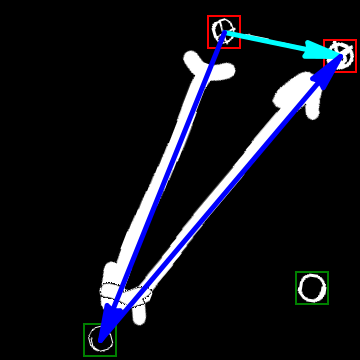
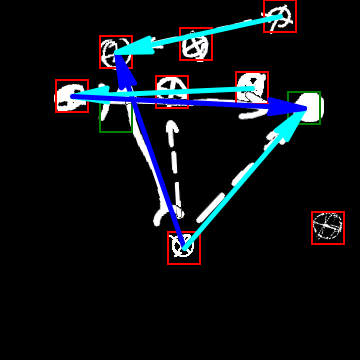
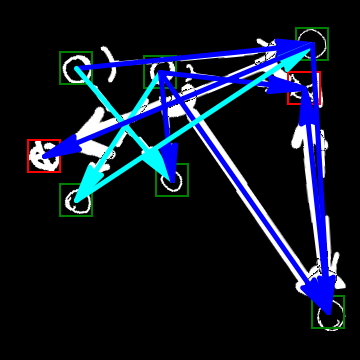
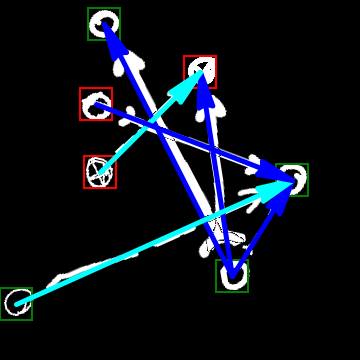
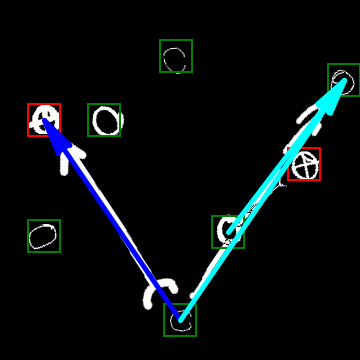

In [5]:
(async () => {
    for (let i = 0; i < images.length; ++i) {
        const ctx = images[i].getContext('2d');
        const [nodes, constraints] = await deepmech.predict(images[i]);
        nodes.forEach(n => {
            const ls = n.maxIndex === 1 ? 'green' : 'red';
            g2().rec({...n, ls, lw:2 }).exe(ctx);
        });
        constraints.forEach(c => {
            const ls = c.maxIndex === 1 ? 'blue' : 'cyan';
            g2().vec({...c, ls, lw:5}).exe(ctx);
        });
    };

    $$.html(`<div style="display:flex; flex-direction: row;"> ${images.map(c => 
        `<img style='margin: 1px; zoom: 0.4' src='${c.toDataURL()}'></img>`).join('')}
    </div>`);
})()

The results are not exactly the same as before, which indicates minor differences in the processing. Whether individual shifts in the 1 pixel range or other factors are responsible for this remain subject of further investigation.